# Housing Price Simulation.

A notebook by *List your names here*.

Then, add alternating code cells and description/markdown cells,
between this top cell and the final "Running DocTest tests" section,
to answer all the elements of the final project programming assignment.

The answer to each part must be clearly identified with,
the text "Step 1" for Step 1, "Step 2" for Step 2, etc.
As noted in the assignment, you may do some of the work in copies of this project
for different sub-experiments,
rather than just putting it all in this notebook,
if you like.

In [20]:
import numpy as np
import doctest
import matplotlib.pyplot as plt

Income: [2.00008337 2.00012652 2.00013533 ... 8.53456626 9.23370052 9.31652005]
Distance: [6.88441840e-05 7.82831286e-05 1.10542345e-04 ... 8.46437132e+00
 9.05358249e+00 1.12770313e+01]


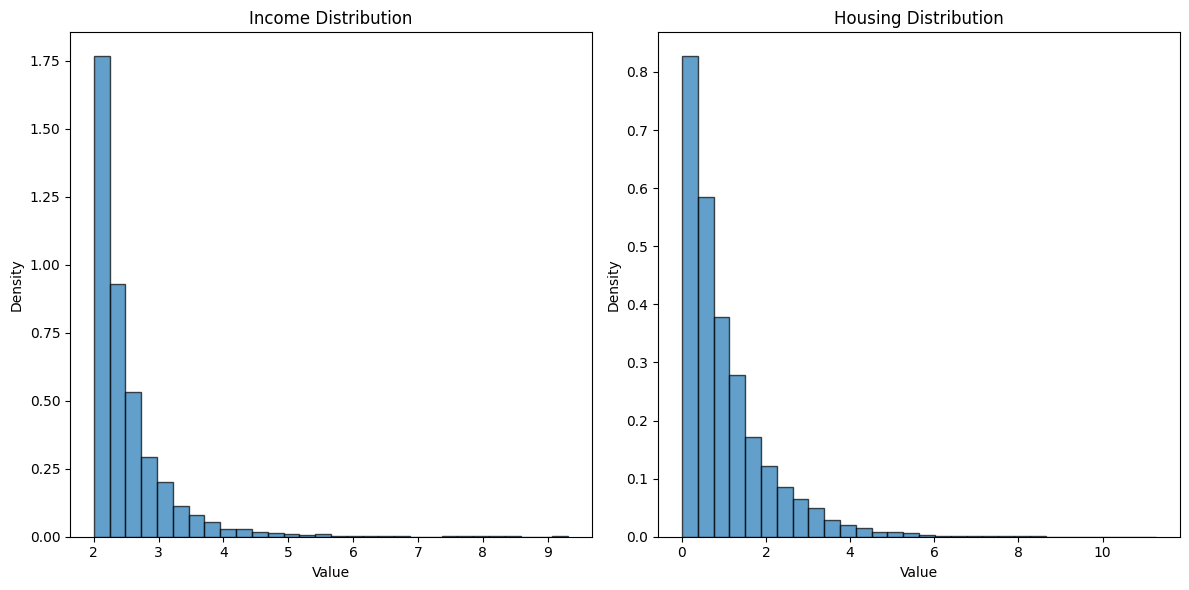

In [21]:
def gen_data(n, y_min, alpha, mu, c, seed=1):

  # Validate parameters
    if y_min <= c:
        raise ValueError
    if alpha <= 1:
        raise ValueError
    if mu <= 0:
        raise ValueError

    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)

    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)

    y = np.sort(y)
    d = np.sort(d)
    return y, d


# Generate samples for visualization
n = 10000
y_min = 2.0
alpha = 5
mu = 1.0
c = 1.5
seed = 1

y_samples, d_samples = gen_data(n, y_min, alpha, mu, c, 1)
print(f'Income: {y_samples}')
print(f'Distance: {d_samples}')

# PLOT DISTRIBUTIONS

plt.figure(figsize=(12, 6))

# INCOME
plt.subplot(1, 2, 1)
plt.hist(y_samples, bins=30, density=True, alpha=0.7, edgecolor="black")
plt.title("Income Distribution")
plt.xlabel("Value")
plt.ylabel("Density")

# HOUSING
plt.subplot(1, 2, 2)
plt.hist(d_samples, bins=30, density=True, alpha=0.7, edgecolor="black")
plt.title("Housing Distribution")
plt.xlabel("Value")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


In [50]:
def compute_statistics(prices):
    average = np.mean(prices)
    median = np.median(prices)
    Q1 = np.percentile(prices, 25)
    Q3 = np.percentile(prices, 75)
    IQR = Q3 - Q1

    statistics = {
        'average': average,
        'median': median,
        'Q1' : Q1,
        'Q3' : Q3,
        'IQR': IQR
    }

    return statistics



In [51]:
def equilibrium_price_recursive(n, c, y, d, j):

    if j < 0 or j >= n:
        raise ValueError(f"Invalid j: {j}. It should be between 0 and {n-1}.")

    if j == 0:
        return c  # Base case: first house price is equal to c

    theta_j = np.exp(-(d[j] - d[j - 1]))
    # Recursive call for the previous house (j-1)
    previous_price = equilibrium_price_recursive(n, c, y, d, j - 1)
    equilibrium_price = theta_j * previous_price + (1 - theta_j) * y[j]
    return equilibrium_price

def calc_all_prices(n, c, y, d):
    prices = []
    for j in range(n):
        prices.append(equilibrium_price_recursive(n, c, y, d, j))
    return np.array(prices)

In [52]:
n = 2000
y_min = 80
alpha = 1.75
mu = 10
c = 50
seed = 1

# Generate data
y, d = gen_data(n, y_min, alpha, mu, c, seed)
print("Incomes:", y)
print("Housing Distances:", d)

# Calculate equilibrium prices
prices = calc_all_prices(n, c, y, d)
print("Equilibrium Prices:", prices)
print("-------")
print(compute_statistics(prices))
# Test the first house price
base_case_price = prices[0]  # This is the price of house j=1
if base_case_price == c:
    print(f"Base Case check passed: {base_case_price}")
else:
    print(f"Base Case check failed: {base_case_price}")

Incomes: [   80.00131797    80.01631458    80.04135394 ...  7256.15946207
 10304.80967487 12462.11066216]
Housing Distances: [1.57651993e-03 2.16472066e-03 3.60106555e-03 ... 6.45360914e+01
 6.93453339e+01 7.20360700e+01]
Equilibrium Prices: [   50.            50.01765043    50.06074386 ...  6966.6635864
 10277.59031958 12313.9324763 ]
-------
{'average': np.float64(182.05135467956612), 'median': np.float64(113.42773170356767), 'Q1': np.float64(87.57892224884824), 'Q3': np.float64(167.92196282406354), 'IQR': np.float64(80.3430405752153)}
Base Case check passed: 50.0


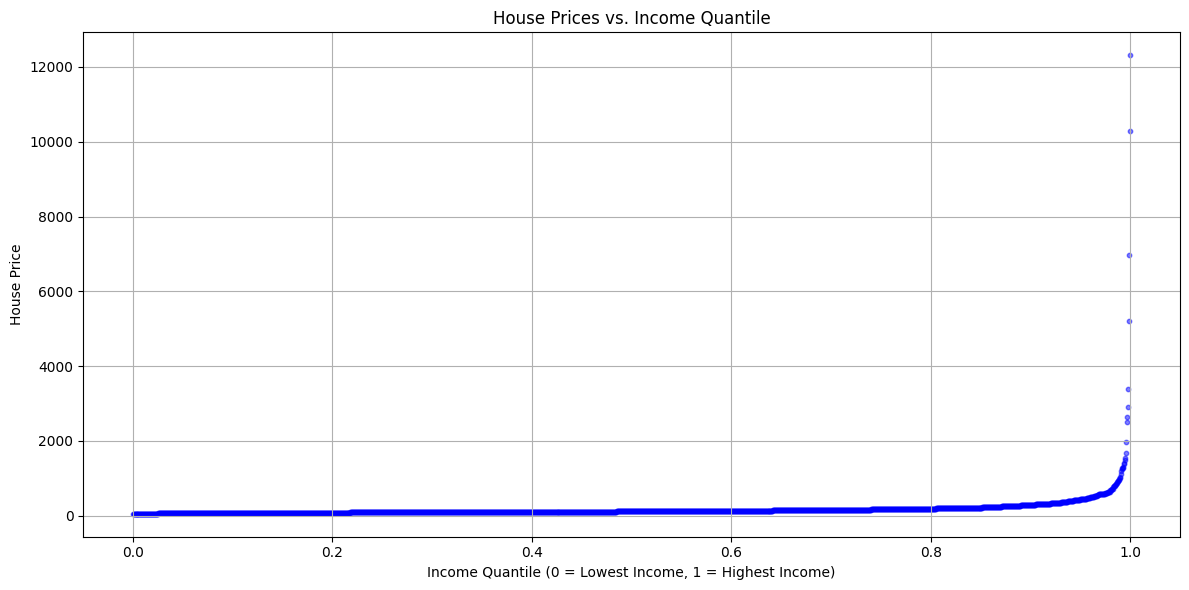

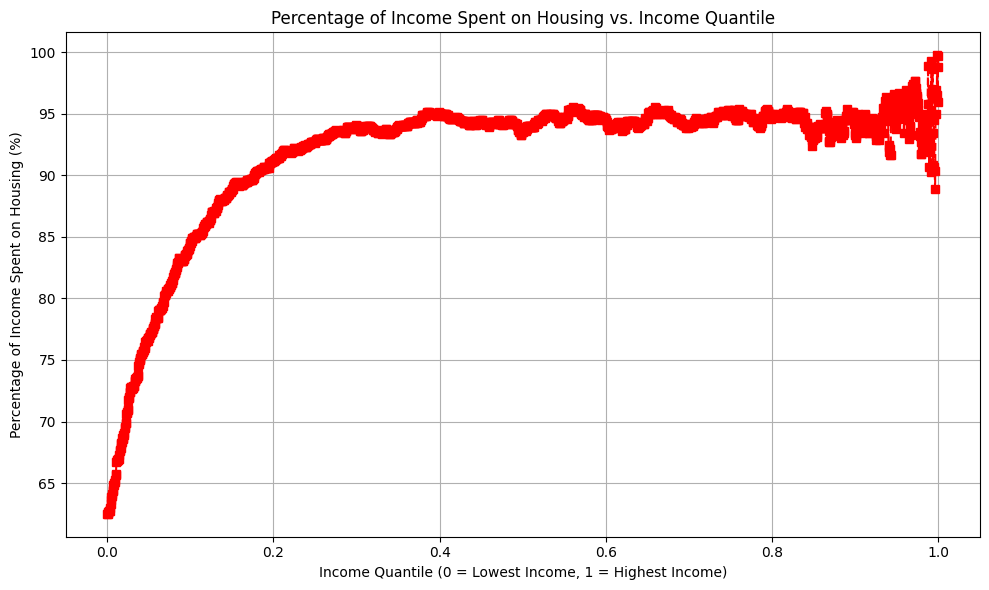

{'average': np.float64(182.05135467956612), 'median': np.float64(113.42773170356767), 'Q1': np.float64(87.57892224884824), 'Q3': np.float64(167.92196282406354), 'IQR': np.float64(80.3430405752153)}


In [54]:

def plot_house_prices(y, prices):
    n = len(y)
    income_quantiles = np.linspace(0, 1, n)

    plt.figure(figsize=(12, 6))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, color='b')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('House Price')
    plt.title('House Prices vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_percentage_income_spent(y, prices):
    n = len(y)
    income_quantiles = np.linspace(0, 1, n)
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_spent = np.where(y != 0, (prices / y) * 100, 0)

    plt.figure(figsize=(10, 6))
    plt.plot(income_quantiles, percentage_spent, marker='s', linestyle='--', color='r')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('Percentage of Income Spent on Housing (%)')
    plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_house_prices(y, prices)
plot_percentage_income_spent(y, prices)
print(compute_statistics(prices))


## Running DocTest tests

This last step gets the DocTest system to check test cases in the documentation comments.
In this course, you won't need to modify the stuff below, or even understand the details.

In [25]:
import doctest
result = doctest.testmod(verbose=False)
if result[0] == 0:
    print(("Congratulations! You have passed all "+str(result[1])+" tests"))
else:
    print("Rats!")

Congratulations! You have passed all 0 tests
